# Predictive Maintenance für Industrie­pumpen
Dieses Jupyter Notebook demonstriert den gesamten Workflow zur prädiktiven Wartung von Pumpen, insbesondere im Kontext der **chemischen Industrie**.

## Datenexploration

In [11]:
import pandas as pd
from IPython.display import display

df = pd.read_csv("pump_data.csv")

# Zeilen/Spalten und Spaltennamen
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())

# Tabellarische Ausgaben
display(df.head(3))
df['Maintenance_Flag'].value_counts(normalize=True)




Shape: (20000, 8)
Columns: ['Pump_ID', 'Temperature', 'Vibration', 'Pressure', 'Flow_Rate', 'RPM', 'Operational_Hours', 'Maintenance_Flag']


,Pump_ID,Temperature,Vibration,Pressure,Flow_Rate,RPM,Operational_Hours,Maintenance_Flag
0,2,127.508350,2.369397,136.021029,6.501492,1444.191922,3966.793672,1
1,4,88.975185,4.541126,147.516973,7.001516,1004.802496,3673.288933,0
2,3,61.832325,2.542112,220.858577,8.824368,2597.662712,5489.061016,1


Maintenance_Flag
0    0.5016
1    0.4984
Name: proportion, dtype: float64

## Feature Engineering
- `Power = Pressure × Flow_Rate`
- `Cumulative_Load = Vibration × Operational_Hours`
- `Vibration_per_hour = Vibration / Operational_Hours`
- `Efficiency = Power / RPM`
- `Log_Vibration_per_hour = log1p(Vibration_per_hour)`

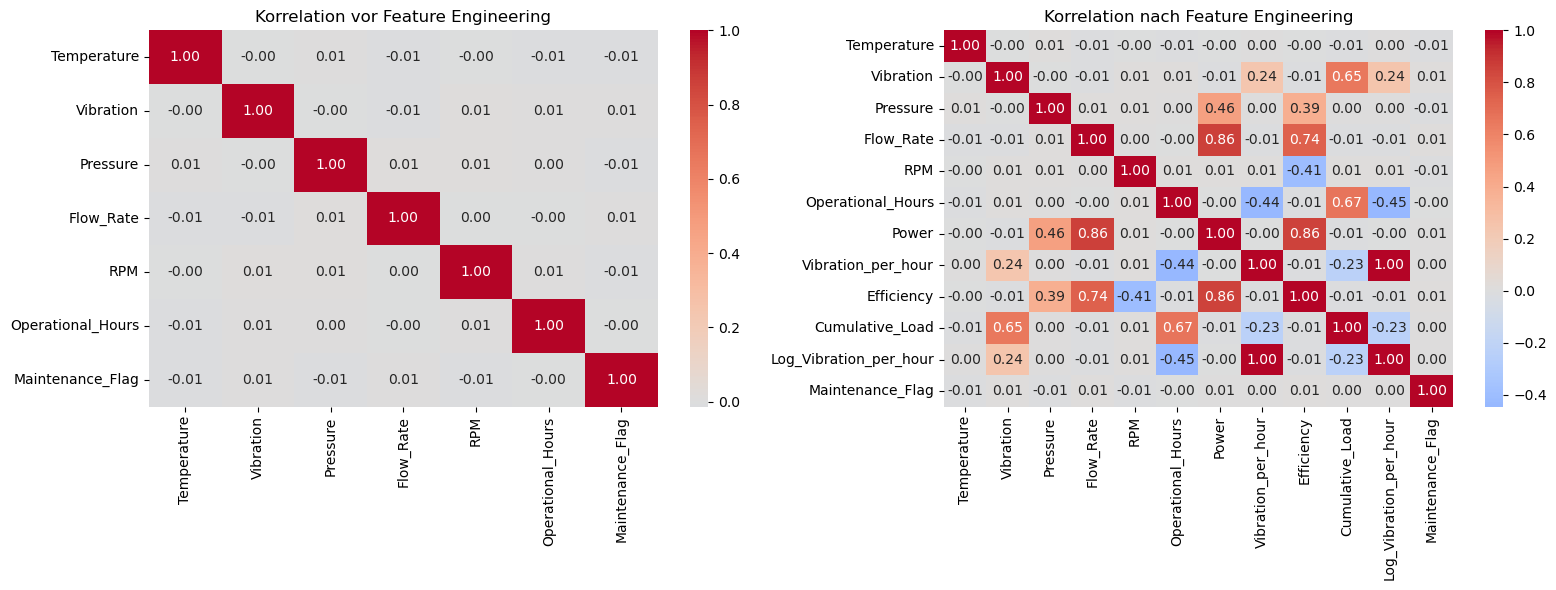

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Daten laden
df = pd.read_csv("pump_data.csv")

# 2) Originale Features
original_features = [
    "Temperature", "Vibration", "Pressure",
    "Flow_Rate", "RPM", "Operational_Hours", "Maintenance_Flag"
]
df_orig = df[original_features].copy()
corr_orig = df_orig.corr()

# 3) Feature Engineering
df["Power"]               = df["Pressure"] * df["Flow_Rate"]
df["Vibration_per_hour"]  = df["Vibration"] / df["Operational_Hours"]
df["Efficiency"]          = df["Power"] / df["RPM"]
df["Cumulative_Load"]     = df["Vibration"] * df["Operational_Hours"]
df["Log_Vibration_per_hour"] = np.log1p(df["Vibration_per_hour"])

# 4) DataFrame mit den neuen + den alten (ohne doppelte Maintenance_Spalte)
engineered_features = [
    "Temperature", "Vibration", "Pressure",
    "Flow_Rate", "RPM", "Operational_Hours",
    "Power", "Vibration_per_hour", "Efficiency",
    "Cumulative_Load", "Log_Vibration_per_hour", "Maintenance_Flag"
]
df_eng = df[engineered_features].replace([np.inf, -np.inf], np.nan).dropna()
corr_eng = df_eng.corr()

# 5) Plot beider Matrizen nebeneinander
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(corr_orig, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[0], center=0)
axes[0].set_title("Korrelation vor Feature Engineering")

sns.heatmap(corr_eng, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[1], center=0)
axes[1].set_title("Korrelation nach Feature Engineering")

plt.tight_layout()
plt.show()


## Clustering & Label-Simulation

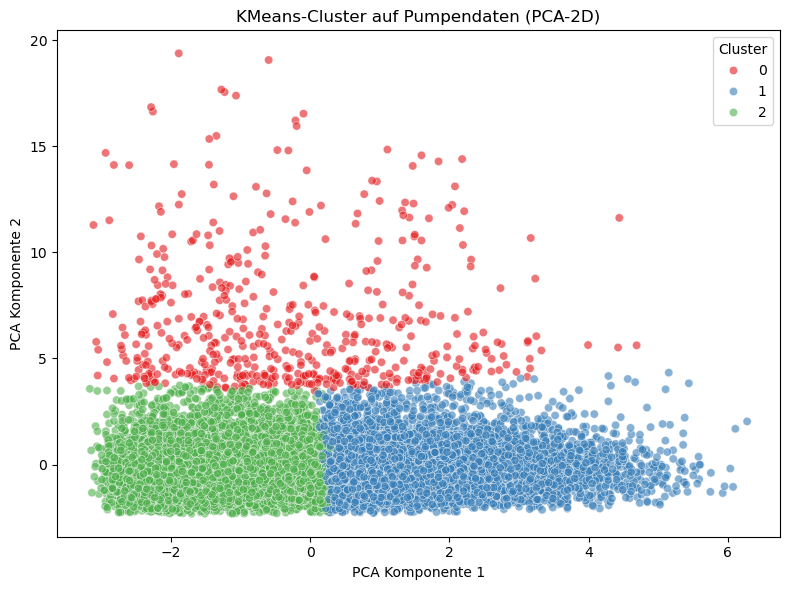

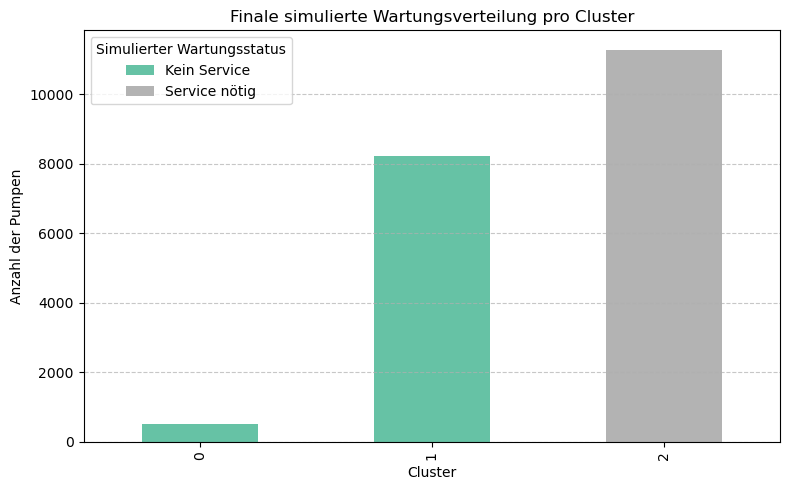

In [19]:

# Komplettes Clustering-Setup mit Fehlerbehebung und Wartungs-Overlay
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# CSV erneut einlesen
df = pd.read_csv("pump_data.csv")

# Feature Engineering
df["Power"] = df["Pressure"] * df["Flow_Rate"]
df["Vibration_per_hour"] = df["Vibration"] / df["Operational_Hours"]
df["Efficiency"] = df["Power"] / df["RPM"]
df["Cumulative_Load"] = df["Vibration"] * df["Operational_Hours"]
df["Log_Vibration_per_hour"] = np.log1p(df["Vibration_per_hour"])

# Relevante Features für Clustering
clustering_features = [
    "Temperature", "Vibration", "Pressure", "Flow_Rate", "RPM", "Operational_Hours",
    "Power", "Vibration_per_hour", "Efficiency", "Cumulative_Load", "Log_Vibration_per_hour"
]

# Nur gültige Daten verwenden
X_clust = df[clustering_features].replace([np.inf, -np.inf], np.nan).dropna()
df_clust = df.loc[X_clust.index]  # Gleiche Zeilen wie nach dropna

# Skalierung
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clust)

# PCA für 2D-Plot
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# KMeans-Clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_scaled)

# Cluster-Zuweisung zurück zur DataFrame
df_clust["Cluster"] = labels

# Plot mit Cluster-Farben
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, palette="Set1", alpha=0.6)
plt.title("KMeans-Cluster auf Pumpendaten (PCA-2D)")
plt.xlabel("PCA Komponente 1")
plt.ylabel("PCA Komponente 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

# Vergleich: Cluster vs. Wartungsstatus
cluster_vs_maintenance = pd.crosstab(df_clust["Cluster"], df_clust["Maintenance_Flag"])


# Komplettdurchlauf mit finalem Ziel: Cluster 2 = immer Wartung, Cluster 0 = nie Wartung, Cluster 1 = Regelbasiert

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# CSV einlesen
df = pd.read_csv("pump_data.csv")

# Feature Engineering
df["Power"] = df["Pressure"] * df["Flow_Rate"]
df["Vibration_per_hour"] = df["Vibration"] / df["Operational_Hours"]
df["Efficiency"] = df["Power"] / df["RPM"]
df["Cumulative_Load"] = df["Vibration"] * df["Operational_Hours"]
df["Log_Vibration_per_hour"] = np.log1p(df["Vibration_per_hour"])

# Clustering Features vorbereiten
clustering_features = [
    "Temperature", "Vibration", "Pressure", "Flow_Rate", "RPM", "Operational_Hours",
    "Power", "Vibration_per_hour", "Efficiency", "Cumulative_Load", "Log_Vibration_per_hour"
]

X_clust = df[clustering_features].replace([np.inf, -np.inf], np.nan).dropna()
df_clust = df.loc[X_clust.index].copy()

# Skalierung und Clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clust)
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df_clust["Cluster"] = kmeans.fit_predict(X_scaled)

# Finales Label erzeugen
df_clust["Maintenance_Flag_Sim_Final"] = 0

# Cluster 2 = immer Wartung
df_clust.loc[df_clust["Cluster"] == 2, "Maintenance_Flag_Sim_Final"] = 1

# Cluster 0 = nie Wartung (implizit durch Startwert)

# Cluster 1 = regelbasiert
load_q70 = df_clust["Cumulative_Load"].quantile(0.7)
eff_q40 = df_clust["Efficiency"].quantile(0.4)
mask_cluster_1 = (
    (df_clust["Cluster"] == 1) &
    (df_clust["Cumulative_Load"] > load_q70) &
    (df_clust["Efficiency"] < eff_q40)
)
df_clust.loc[mask_cluster_1, "Maintenance_Flag_Sim_Final"] = 1

# Crosstab und Plot
cluster_vs_final = pd.crosstab(df_clust["Cluster"], df_clust["Maintenance_Flag_Sim_Final"])

cluster_vs_final.plot(
    kind="bar",
    stacked=True,
    colormap="Set2",
    figsize=(8, 5)
)

plt.title("Finale simulierte Wartungsverteilung pro Cluster")
plt.xlabel("Cluster")
plt.ylabel("Anzahl der Pumpen")
plt.legend(title="Simulierter Wartungsstatus", labels=["Kein Service", "Service nötig"])
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()







## Hyperparameter-Optimierung mit Grid Search

In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from xgboost import XGBClassifier

# CSV laden – dein lokaler Pfad
df = pd.read_csv("pump_data.csv")

# Feature Engineering
df["Power"] = df["Pressure"] * df["Flow_Rate"]
df["Vibration_per_hour"] = df["Vibration"] / df["Operational_Hours"]
df["Efficiency"] = df["Power"] / df["RPM"]
df["Cumulative_Load"] = df["Vibration"] * df["Operational_Hours"]
df["Log_Vibration_per_hour"] = np.log1p(df["Vibration_per_hour"])

# Clustering zur Label-Simulation
features_clust = [
    "Temperature", "Vibration", "Pressure", "Flow_Rate", "RPM", "Operational_Hours",
    "Power", "Vibration_per_hour", "Efficiency", "Cumulative_Load", "Log_Vibration_per_hour"
]
X_clust = df[features_clust].replace([np.inf, -np.inf], np.nan).dropna()
df_clust = df.loc[X_clust.index].copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clust)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df_clust["Cluster"] = kmeans.fit_predict(X_scaled)

# Simuliertes Label
df_clust["Maintenance_Flag_Sim_Final"] = 0
df_clust.loc[df_clust["Cluster"] == 2, "Maintenance_Flag_Sim_Final"] = 1

# Optional: Cluster 1 regelbasiert
load_q70 = df_clust["Cumulative_Load"].quantile(0.7)
eff_q40 = df_clust["Efficiency"].quantile(0.4)
mask_cluster_1 = (
    (df_clust["Cluster"] == 1) &
    (df_clust["Cumulative_Load"] > load_q70) &
    (df_clust["Efficiency"] < eff_q40)
)
df_clust.loc[mask_cluster_1, "Maintenance_Flag_Sim_Final"] = 1

# Modell-Features und Ziel
features_model = features_clust
target = "Maintenance_Flag_Sim_Final"
df_model = df_clust[features_model + [target]].replace([np.inf, -np.inf], np.nan).dropna()

X = df_model[features_model]
y = df_model[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
xgb = XGBClassifier(eval_metric='logloss', random_state=42)

# Grid Search Setup
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
}

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    verbose=1,
    n_jobs=-1
)


grid_search.fit(X_train, y_train)

# Evaluation
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print("Beste Parameterkombination:\n", grid_search.best_params_)
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Beste Parameterkombination:
 {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      1746
           1       1.00      0.99      1.00      2254

    accuracy                           1.00      4000
   macro avg       0.99      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000



## Finale Evaluation

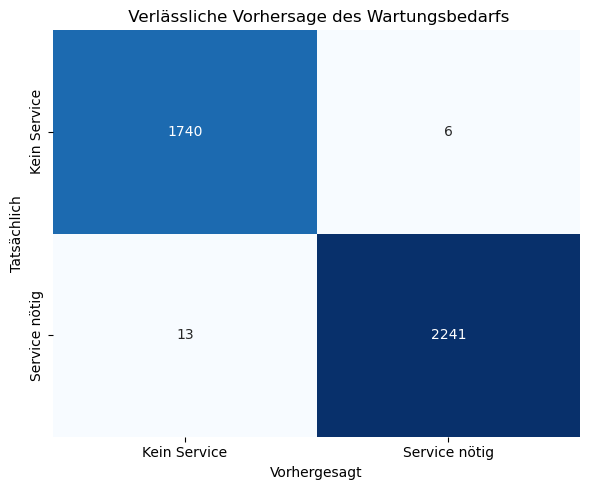

In [21]:
# Nach Kernel-Reset: Finales Diagramm mit Konfusionsmatrix
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# CSV laden
df = pd.read_csv("pump_data.csv")

# Feature Engineering
df["Power"] = df["Pressure"] * df["Flow_Rate"]
df["Vibration_per_hour"] = df["Vibration"] / df["Operational_Hours"]
df["Efficiency"] = df["Power"] / df["RPM"]
df["Cumulative_Load"] = df["Vibration"] * df["Operational_Hours"]
df["Log_Vibration_per_hour"] = np.log1p(df["Vibration_per_hour"])

# Clustering für simuliertes Label
features_clust = [
    "Temperature", "Vibration", "Pressure", "Flow_Rate", "RPM", "Operational_Hours",
    "Power", "Vibration_per_hour", "Efficiency", "Cumulative_Load", "Log_Vibration_per_hour"
]
X_clust = df[features_clust].replace([np.inf, -np.inf], np.nan).dropna()
df_clust = df.loc[X_clust.index].copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clust)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df_clust["Cluster"] = kmeans.fit_predict(X_scaled)

# Simuliertes Label erzeugen
df_clust["Maintenance_Flag_Sim_Final"] = 0
df_clust.loc[df_clust["Cluster"] == 2, "Maintenance_Flag_Sim_Final"] = 1
load_q70 = df_clust["Cumulative_Load"].quantile(0.7)
eff_q40 = df_clust["Efficiency"].quantile(0.4)
mask_cluster_1 = (
    (df_clust["Cluster"] == 1) &
    (df_clust["Cumulative_Load"] > load_q70) &
    (df_clust["Efficiency"] < eff_q40)
)
df_clust.loc[mask_cluster_1, "Maintenance_Flag_Sim_Final"] = 1

# Modell-Features
features_model = features_clust
target = "Maintenance_Flag_Sim_Final"
df_model = df_clust[features_model + [target]].replace([np.inf, -np.inf], np.nan).dropna()

X = df_model[features_model]
y = df_model[target]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Bestes Modell laut GridSearch
xgb = XGBClassifier(
    n_estimators=200,
    max_depth=3,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42
)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

# Konfusionsmatrix plotten
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Kein Service", "Service nötig"],
            yticklabels=["Kein Service", "Service nötig"])
plt.xlabel("Vorhergesagt")
plt.ylabel("Tatsächlich")
plt.title(" Verlässliche Vorhersage des Wartungsbedarfs")
plt.tight_layout()
plt.show()
